In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
def nonlinearity(x):
    return 1/(1+np.exp(-x))

def ori_matrix(x, mean, var):
    return stats.norm.pdf(x, mean, var) + stats.norm.pdf(x, mean+180, var) + stats.norm.pdf(x, mean-180, var) 

def weight_normalisation(matrix):
    """
    Makes sum of columns equal to zero 
    """
    # sum_incoming_weights = np.sum(W_FF, axis=0) + np.sum(W_EE, axis=0)
    # sum_all_weights = np.sum(W_FF) + np.sum(W_EE)

    # return sum_all_weights * W_FF / sum_incoming_weights

    return matrix / np.sum(matrix, axis=0)

def get_input(N, theta):

    theta_y = np.linspace(0, 180, N) # center of tuning curves 
    d = np.abs(theta - theta_y)      # distance to input theta
    sigma = 10                       # response width
    amp = 100                         # response amplitude

    y = amp * np.exp(-(d**2)/(2*sigma**2))

    return y

def simulate(theta, T, E_init, W_FF_init, plasticity=True):
    input = get_input(N, theta) 
    timesteps = int(T / delta_t)

    # initialisation
    I = np.ones((N, timesteps))   
    E = np.zeros((N, timesteps))    
    E[:, 0] = E_init      
    
    W_FF = np.zeros((N, N, timesteps))      # feedforward weights
    W_FF[:, :, 0] = W_FF_init

    for i in range(timesteps - 1):
        
        E[:, i + 1] = E[:, i] + delta_t * (
            - E[:, i] 
            + np.dot(W_EE, nonlinearity(E[:, i]))
            - np.dot(W_EI, nonlinearity(I[:, i]))
            + np.dot(W_FF[:, :, i], input)
        ) / tau_E

        I[:, i + 1] = I[:, i] + delta_t * (
            - I[:, i] 
            + np.dot(W_IE, nonlinearity(E[:, i]))
        ) / tau_E


        if plasticity == True:
            W_FF[:, :, i + 1] = W_FF[:, :, i] + delta_t * (
                epsilon * np.outer(input, nonlinearity(E[:, i]))
            ) / tau_weights

            W_FF[:, :, i + 1] = weight_normalisation(W_FF[:, :, i + 1])

        else: W_FF[:, :, i + 1] = W_FF[:, :, i]

    return E, W_FF[:, :, -1]

### Initialisation

In [125]:
N = int(180)   # number of neurons per layer
delta_t = 0.1 

tau_E = 1  # 20 for exc, 10 for inh 
tau_weights = 40
epsilon = 0.001        # learning rate for the weights

E_init = np.random.normal(0, 1, size=N)   # initial E activations
I_init = np.random.normal(0, 1, size=N)   # initial I activations

W_FF_init = np.zeros((N, N))
W_EE = np.zeros((N, N))      # recurrent weights
W_EI = np.zeros((N, N))      # I -> E weights
W_IE = np.zeros((N, N))      # E -> I weights

x = np.linspace(0, 180, N)
W_FF_var = 30                 # variance of feedforward weights
W_EE_var = 30                 # variance of recurrent weights
W_IE_var = 30
W_EI_var = 30

x = np.linspace(0, 180, N)

for i in range(N):
    W_FF_init[:, i] = ori_matrix(x, x[i], W_FF_var)
    W_EE[:, i] = ori_matrix(x, x[i], W_EE_var)
    W_IE[:, i] = ori_matrix(x, x[i], W_IE_var)
    W_EI[:, i] = (ori_matrix(x, x[i], W_EI_var) - ori_matrix(x, x[i], W_EI_var-15)) + 0.22



### Test tuning curves

In [126]:
def test_tuning(T, angles, E, W_FF):

    responses = []
    for theta in angles:
        E, W_FF = simulate(theta, T, E[:, -1], W_FF, plasticity=False)
        responses.append(E[:, -1][None])
    
    tuning_tests = np.concatenate(responses, axis=0).T

    return tuning_tests, W_FF


def experience(T, E, W_FF, runs):
    E_total = []
    for run in range(int(runs)):
        theta = np.random.choice(int(180), replace=False)
        E, W_FF = simulate(theta, T, E[:, -1], W_FF, plasticity=True)
        E_total.append(E)

    return np.concatenate(E_total, axis=1), W_FF

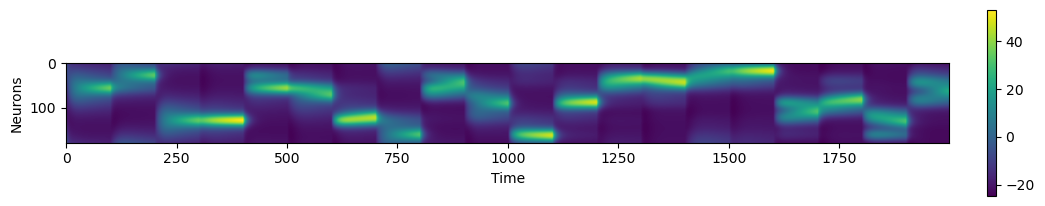

In [130]:

fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(E_total)
ax.set_ylabel('Neurons')
ax.set_xlabel('Time')
plt.colorbar(im, fraction=0.01, pad=0.04)

In [129]:
T_test = 8
T_experience = 10
n_runs = 20
angles = np.linspace(0, 180, 60)

n_days = 5

# Initialise 
E_new, W_FF_new = simulate(0, T, E_init, W_FF_init, plasticity=False)
 
tunings_all_days = []

for day in range(n_days):

    # Test tuning 
    tuning, W_FF_new = test_tuning(T_test, angles, E_new, W_FF_new)
    
    # Experience-dependent plasticity 
    E_total, W_FF_new = experience(T_experience, E_new, W_FF_new, n_runs)

    tunings_all_days.append(tuning)


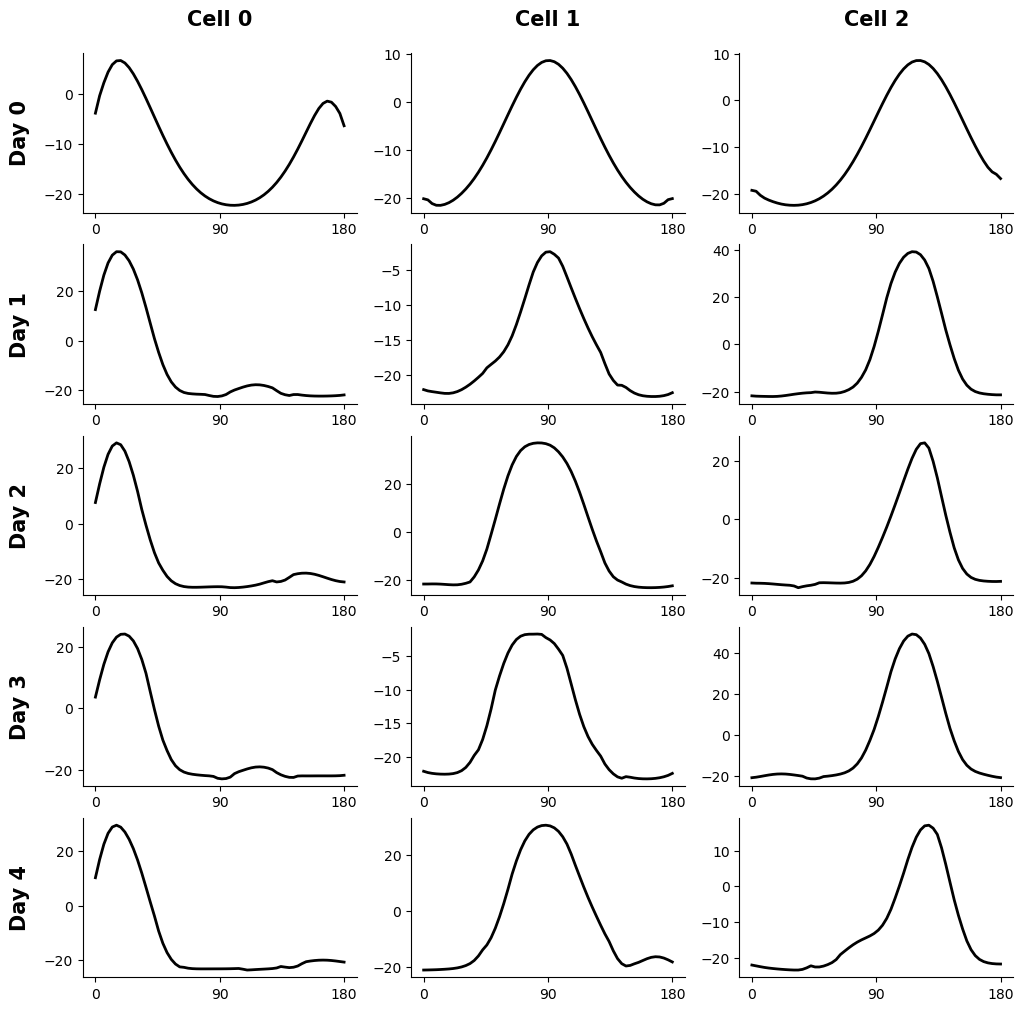

In [121]:

n_cells = 3

fig, axs = plt.subplots(n_days, n_cells, figsize=(12, 12), dpi=100)

pref_angles = [10, 90, 120]

for i in range(n_days):
    for j in range(n_cells):
        axs[i, j].plot(angles, tunings_all_days[i][pref_angles[j], :], lw=2, c='k')
        axs[i, j].set_xticks([0, 90, 180])
        axs[i, j].set_xticklabels([0, 90, 180])
        sns.despine(ax=axs[i, j])

        if i==0: axs[i, j].set_title('Cell %s' %j, fontsize=15, pad=20, weight='bold')
        if j==0: axs[i, j].set_ylabel('Day %s' %i,  fontsize=15, labelpad=10, weight='bold')

    


In [122]:
preferences = []
for day in range(n_days):
    preferences.append(np.argmax(tunings_all_days[day], axis=1))

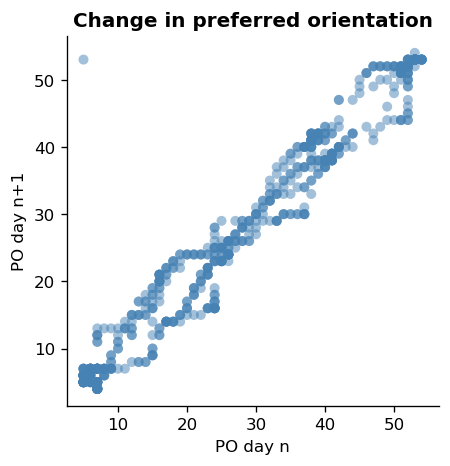

In [123]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)

for n in range(n_days-1):
    ax.scatter(preferences[n], preferences[n+1], alpha=0.5, fc='steelblue', ec=None)

ax.set_ylabel('PO day n+1')
ax.set_xlabel('PO day n')
ax.set_title('Change in preferred orientation', fontweight='bold')
sns.despine()